In [40]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from collections import OrderedDict
import umap
from datetime import datetime, timedelta
from types import SimpleNamespace 
# Add parent path for import
import sys
sys.path.append("..")
from data.data_utils import *
from data.dataloader_detection import load_dataset_detection
from data.dataloader_classification import load_dataset_classification
import utils 
from model.model import NeuroGNN_Classification
from constants import *
pd.set_option('display.max_columns', 50)
os.chdir(os.getcwd().split('NeuroGNN')[0] + 'NeuroGNN')
os.getcwd()


'/tank/users/arash/W4H/eeg/NeuroGNN'

In [2]:
CLASSIFICATION_SAVED_MODEL_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_classification_clip_60/neurognn/train/train-112/'
DETECTION_SAVED_MODEL_PATH = '/home/users/arash/W4H/eeg/saved_results/seizure_detection_clip_60/neurognn/train/train-84/'

In [3]:
def evaluate(
        model,
        dataloader,
        args,
        save_dir,
        device,
        is_test=False,
        nll_meter=None,
        eval_set='dev',
        best_thresh=0.5):
    # To evaluate mode
    model.eval()

    # Define loss function
    if args.task == 'detection':
        loss_fn = nn.BCEWithLogitsLoss().to(device)
    else:
        loss_fn = nn.CrossEntropyLoss().to(device)

    y_pred_all = []
    y_true_all = []
    y_prob_all = []
    file_name_all = []
    with torch.no_grad(), tqdm(total=len(dataloader.dataset)) as progress_bar:
        for x, y, seq_lengths, supports, _, file_name in dataloader:
            batch_size = x.shape[0]

            # Input seqs
            x = x.to(device)
            y = y.view(-1).to(device)  # (batch_size,)
            seq_lengths = seq_lengths.view(-1).to(device)  # (batch_size,)
            for i in range(len(supports)):
                supports[i] = supports[i].to(device)

            # Forward
            # (batch_size, num_classes)
            if args.model_name == "dcrnn":
                logits = model(x, seq_lengths, supports)
            elif args.model_name == "densecnn":
                x = x.transpose(-1, -2).reshape(batch_size, -1, args.num_nodes) # (batch_size, len*freq, num_nodes)
                logits = model(x)
            elif args.model_name == "lstm" or args.model_name == "cnnlstm":
                logits = model(x, seq_lengths)
            elif args.model_name == "neurognn":
                logits = model(x)
            else:
                raise NotImplementedError

            if args.num_classes == 1:  # binary detection
                logits = logits.view(-1)  # (batch_size,)
                y_prob = torch.sigmoid(logits).cpu().numpy()  # (batch_size, )
                y_true = y.cpu().numpy().astype(int)
                y_pred = (y_prob > best_thresh).astype(int)  # (batch_size, )
            else:
                # (batch_size, num_classes)
                y_prob = F.softmax(logits, dim=1).cpu().numpy()
                y_pred = np.argmax(y_prob, axis=1).reshape(-1)  # (batch_size,)
                y_true = y.cpu().numpy().astype(int)

            # Update loss
            loss = loss_fn(logits, y)
            if nll_meter is not None:
                nll_meter.update(loss.item(), batch_size)

            y_pred_all.append(y_pred)
            y_true_all.append(y_true)
            y_prob_all.append(y_prob)
            file_name_all.extend(file_name)

            # Log info
            progress_bar.update(batch_size)

    y_pred_all = np.concatenate(y_pred_all, axis=0)
    y_true_all = np.concatenate(y_true_all, axis=0)
    y_prob_all = np.concatenate(y_prob_all, axis=0)

    # Threshold search, for detection only
    if (args.task == "detection") and (eval_set == 'dev') and is_test:
        best_thresh = utils.thresh_max_f1(y_true=y_true_all, y_prob=y_prob_all)
        # update dev set y_pred based on best_thresh
        y_pred_all = (y_prob_all > best_thresh).astype(int)  # (batch_size, )
    else:
        best_thresh = best_thresh

    scores_dict, _, _ = utils.eval_dict(y_pred=y_pred_all,
                                        y=y_true_all,
                                        y_prob=y_prob_all,
                                        file_names=file_name_all,
                                        average="binary" if args.task == "detection" else "weighted")

    eval_loss = nll_meter.avg if (nll_meter is not None) else loss.item()
    results_list = [('loss', eval_loss),
                    ('acc', scores_dict['acc']),
                    ('F1', scores_dict['F1']),
                    ('recall', scores_dict['recall']),
                    ('precision', scores_dict['precision']),
                    ('best_thresh', best_thresh)]
    if 'auroc' in scores_dict.keys():
        results_list.append(('auroc', scores_dict['auroc']))
    results = OrderedDict(results_list)

    return results, y_pred_all, y_true_all, y_prob_all

### Building the datasets and the modesl

In [14]:
# load args used to train saved models
classification_args = SimpleNamespace(**json.load(open(f'{CLASSIFICATION_SAVED_MODEL_PATH}/args.json')))
detection_args = SimpleNamespace(**json.load(open(f'{DETECTION_SAVED_MODEL_PATH}/args.json')))

distances_df = pd.read_csv('./data/electrode_graph/distances_3d.csv')
dist_adj, _, _ = utils.get_extended_adjacency_matrix(distances_df, INCLUDED_CHANNELS, ELECTRODES_REGIONS)
initial_sem_embs = utils.get_semantic_embeds()

print('building detection dataset...')
# load datasets
dataloaders_detection, _, scaler_detection = load_dataset_detection(
    input_dir=detection_args.input_dir,
    raw_data_dir=detection_args.raw_data_dir,
    train_batch_size=detection_args.train_batch_size,
    test_batch_size=detection_args.test_batch_size,
    time_step_size=detection_args.time_step_size,
    max_seq_len=detection_args.max_seq_len,
    standardize=True,
    num_workers=detection_args.num_workers,
    augmentation=detection_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=detection_args.graph_type,
    top_k=detection_args.top_k,
    filter_type=detection_args.filter_type,
    use_fft=detection_args.use_fft,
    sampling_ratio=1,
    seed=123,
    preproc_dir=detection_args.preproc_dir,
    augment_metaseries=True)

print('building classification dataset...')
dataloaders_classification, _, scaler = load_dataset_classification(
    input_dir=classification_args.input_dir,
    raw_data_dir=classification_args.raw_data_dir,
    train_batch_size=classification_args.train_batch_size,
    test_batch_size=classification_args.test_batch_size,
    time_step_size=classification_args.time_step_size,
    max_seq_len=classification_args.max_seq_len,
    standardize=True,
    num_workers=classification_args.num_workers,
    padding_val=0.,
    augmentation=classification_args.data_augment,
    adj_mat_dir='./data/electrode_graph/adj_mx_3d.pkl',
    graph_type=classification_args.graph_type,
    top_k=classification_args.top_k,
    filter_type=classification_args.filter_type,
    use_fft=classification_args.use_fft,
    preproc_dir=classification_args.preproc_dir,
    augment_metaseries=True)

# load saved models
print('loading saved models...')
model_detection = NeuroGNN_Classification(detection_args, detection_args.num_classes, detection_args.device, 
                                        dist_adj, initial_sem_embs, 
                                        meta_node_indices=META_NODE_INDICES)
model_detection = utils.load_model_checkpoint(DETECTION_SAVED_MODEL_PATH+'best.pth.tar', model_detection)
model_detection.to(detection_args.device)

model_classification = NeuroGNN_Classification(classification_args, classification_args.num_classes, classification_args.device,
                                            dist_adj, initial_sem_embs,
                                            meta_node_indices=META_NODE_INDICES)
model_classification = utils.load_model_checkpoint(CLASSIFICATION_SAVED_MODEL_PATH+'best.pth.tar', model_classification)
model_classification.to(classification_args.device)
print('All done!')

building detection dataset...
number of seizure files:  3594
Number of clips in train: 7188
Number of clips in dev: 5503
Number of clips in test: 8848
building classification dataset...
loading saved models...
All done!


### Model evaluations

#### Detection model

In [25]:
det_test_results, det_test_preds, det_test_labels, det_test_probs = evaluate(model_detection, dataloaders_detection['test'],
                                                                            detection_args,
                                                                            detection_args.save_dir,
                                                                            detection_args.device,
                                                                            is_test=True,
                                                                            nll_meter=None,
                                                                            eval_set='test',
                                                                            best_thresh=0.7512)

classification_test_results, classification_test_preds, classification_test_labels, classification_test_probs = evaluate(model_classification, dataloaders_classification['test'],
                                                                            classification_args,
                                                                            classification_args.save_dir,
                                                                            classification_args.device,
                                                                            is_test=True,
                                                                            nll_meter=None,
                                                                            eval_set='test',
                                                                            best_thresh=0.5)

100%|██████████| 521/521 [00:03<00:00, 154.95it/s]


In [32]:
classification_test_probs[0].sum()

1.0

<Figure size 800x600 with 0 Axes>

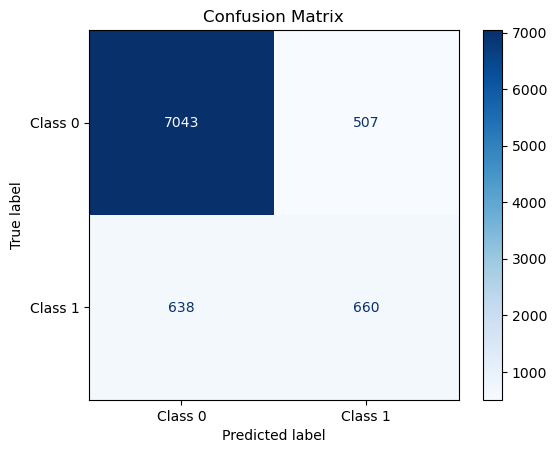

In [34]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(det_test_labels, det_test_preds)

# Visualize the confusion matrix
class_names = ['Class 0', 'Class 1']  # Replace with your class names
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Display the confusion matrix plot
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

<Figure size 1000x800 with 0 Axes>

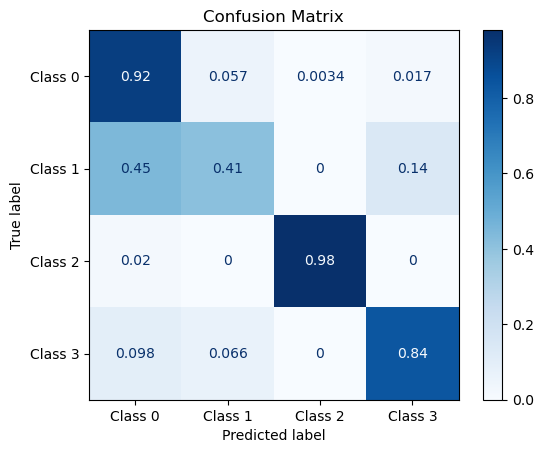

In [39]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(classification_test_labels, classification_test_preds, normalize='true')

# Visualize the confusion matrix
num_classes = len(np.unique(classification_test_labels))
class_names = [f'Class {i}' for i in range(num_classes)]  # Replace with your class names

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Display the confusion matrix plot
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

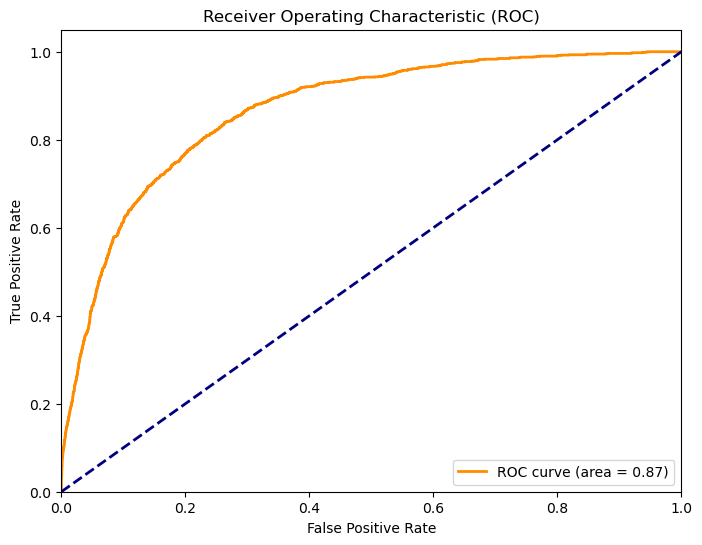

In [41]:
# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(det_test_labels, det_test_probs)

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()